In [1]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')
import StatsTools

## Point

In [2]:
sheetloc = '/data8/Human/FungiPaper/Datasheets/'
fig_loc = '/data8/Human/FungiPaper/figures/'

## Load genome coverage information

In [3]:
Gdb = pd.read_csv(sheetloc + 'MappingListGamma_coverageInfantsParsed_filtered_v1.csv')

## Load antibiotic info

In [4]:
Ndb = pd.read_csv(sheetloc + 'parsed_AB_info_v1.csv')

### Set up colormap

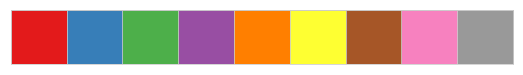

In [5]:
relevent_genomes = Gdb['common_name'].unique()
relevent_infants = Gdb['infant'].unique()
Bdb = Gdb[(Gdb['common_name'].isin(relevent_genomes)) & \
          (Gdb['infant'].isin(relevent_infants))]

cp = sns.choose_colorbrewer_palette('qualitative')
cm = {g:c for g,c in zip(relevent_genomes, cp)}

### Subset and handle DOL

In [6]:
Bdb = Bdb[Bdb['loc'] == 'G']
Bdb['DOL'] = [int(x[7:10]) + (int(x[11])-1)*0.5 if x[:6] == 'SP_CRL' \
              else d for x,d in zip(Bdb['sample'], Bdb['DOL'])]

In [7]:
order = ['Candida albicans', 'Purpureocillium lilacinum',
         'Candida parapsilosis',
       'Candida tropicalis', 'Clavispora lusitaniae', 
       'Malassezia pachydermatis', 'Malassezia sympodialis', 'Trichosporon asahii', 
       ]

### Print out the max values (to manually add to plot)

In [8]:
i2m = defaultdict(int)
for gen, gdb in Bdb.groupby('common_name'):
    for inf, db in gdb.groupby('infant'):
        if len(db[db['breadth'] >= .1]) == 0:
            continue
        db = db[db['DOL'] != 0]
        i2m[inf] = max(db['pp'].max(), i2m[inf])

        
for w in sorted(i2m, key=i2m.get, reverse=True):
    print(w, i2m[w])

iorder = sorted(i2m, key=i2m.get, reverse=True)

N1_023 96.25355432903393
N5_264 78.40742912346592
S2_018 70.8187854225256
N3_182 55.265128691226785
S2_012 34.21820216877373
N5_275 28.78841034551544
S2_002 16.50252969078924
S2_006 13.138545440785556
N2_070 5.4793211218582165
SP_CRL 4.5155646363945925
N5_254 0.6039299683367481
N4_116 0.5712483081434694
N2_064 0.4061167480109252


## Plot

https://stackoverflow.com/questions/27543605/creating-sparklines-using-matplotlib-in-python

Candida albicans
N1_023


/home/mattolm/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


N5_264
S2_006
N2_070
SP_CRL
N2_064
Purpureocillium lilacinum
S2_018
S2_012
N4_116
Candida parapsilosis
N3_182
N5_275
Candida tropicalis
N5_254
Clavispora lusitaniae
N2_070
Malassezia pachydermatis
S2_002
Malassezia sympodialis
N5_275
Trichosporon asahii
N5_275


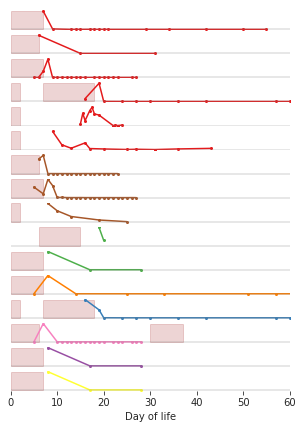

In [11]:
import matplotlib.patches as patches
Fdb = Bdb.copy()

# order infants
Fdb['infant'] = pd.Categorical(Fdb['infant'], iorder)
Fdb = Fdb.sort_values('infant')

# order names
Fdb['common_name'] = pd.Categorical(Fdb['common_name'], order)
Fdb = Fdb.sort_values('common_name')

# set up figure
num_plots = (len(Fdb[Fdb['breadth'] > 0.1].drop_duplicates(\
        subset=['common_name', 'infant'])))
fig = plt.figure()
sns.set_style('white')

# make the plots
i = 1
axs = []
for gen, gdb in Fdb.groupby('common_name'):
    print(gen)
    for inf, db in gdb.groupby('infant'):
        if len(db[db['breadth'] >= .1]) == 0:
            continue
        db = db[db['DOL'] != 0]
        db.sort_values('DOL', inplace=True)
        
        if len(db) == 0:
            print("FUCKING {0}".format(inf))
            continue
            
        if i == 1: # first plot
            ax1 = fig.add_subplot(num_plots,1,i) # nrows, ncols, plot_number, top sparkline)
            ax = ax1
        elif i == (num_plots): # last plot
            axL = fig.add_subplot(num_plots,1,i, sharex=ax1)
            ax = axL
        else:
            ax = fig.add_subplot(num_plots,1,i, sharex=ax1)
        i += 1
        
        ax.plot(db['DOL'], db['pp'], c=cm[gen], marker='o', markersize=2)
        ax.axhline(0, c='grey', alpha=0.25)
        axs.append(ax)
        
        # Add antibiotic info
        d = Ndb[Ndb['infant'] == inf].drop_duplicates(subset=['start', 'end'])
        for ii, row in d.iterrows():
            h = db['pp'].max()
            y = 0
            x = row['start']
            w = int(row['end']) - x

            ax.add_patch(patches.Rectangle((x,y),w,h,color='brown', alpha=0.2, zorder=0))
        
        #print("{0} {1} {2:.2f}".format(gen, inf, db['pp'].max()))
        print("{1}".format(gen, inf, db['pp'].max()))
        #print("{2:.1f}%".format(gen, inf, db['pp'].max()))
        #print("{0} {1}".format(db['DOL'].min(), db['DOL'].max()))
        

        
# remove borders
for axes in axs:
    plt.setp(axes.get_xticklabels(), visible=False)
    plt.setp(axes.get_yticklabels(), visible=False)
    plt.setp(axes.get_xticklines(), visible=False)
    plt.setp(axes.get_yticklines(), visible=False)
    plt.setp(axes.spines.values(), visible=False)
    
# bottom
plt.setp(axL.get_xticklabels(), visible=True)
plt.setp(axL.get_xticklines(), visible=True)
axL.xaxis.tick_bottom()
           
# display
plt.xlim(0,60)
plt.xticks([0,10,20,30,40,50,60], [0,10,20,30,40,50,60])
plt.xlabel('Day of life')
fig.set_size_inches(5, 7)
plt.savefig(fig_loc + 'sparkline_v2.pdf', bbox_inches='tight')
plt.show()